<a href="https://colab.research.google.com/github/drdww/OPIM5641/blob/main/Module5/M5_1/5_Assignment_Alternative_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Network Models: Machine assignment (extracted from the textbook)

Related Readings:

* Pyomo Cookbook: https://github.com/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/03.01-Transportation-Networks.ipynb
* Powell: Chapter 10 (Optimization of Network Models)


# Problem Description

Suppose we have 4 machines and 4 jobs. The time it takes to do each job on each machine depends on the job and the machine; the information is given below: 

TIME	| J1	| J2	| J3	| J4
--- | --- | --- | --- | ---
M1	| 20	|15	|11	|16
M2	| 15	|13	|5	|10
M3	| 22	|14	|9	|9
M4	| 18	|14	|7	|11


Which machine should do which job so as to minimize the total time required to do all of the jobs?

* Each machine should do exactly one job

* Each job is executed by exactly one machine

* We can also think of this as employees being assigned to jobs

Note that we can create a network of assignments (see below).

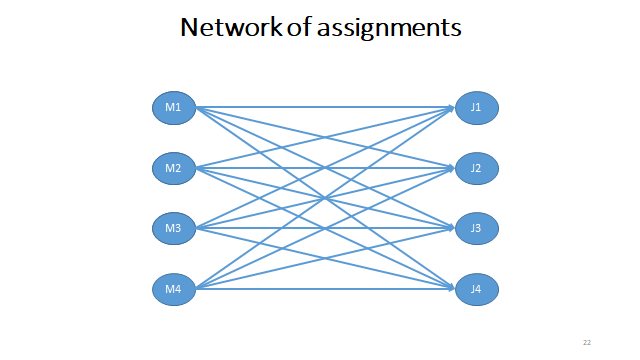

In [ ]:
# before you do anything...
# mount your drive!
# click folder on the left...
# import modules

%matplotlib inline
from pylab import *

import shutil
import sys
import os.path

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not (shutil.which("cbc") or os.path.isfile("cbc")):
    if "google.colab" in sys.modules:
        !apt-get install -y -qq coinor-cbc
    else:
        try:
            !conda install -c conda-forge coincbc 
        except:
            pass

assert(shutil.which("cbc") or os.path.isfile("cbc"))

from pyomo.environ import *
# ensure you have cbc installed
!apt-get install -y -qq coinor-cbc

     |████████████████████████████████| 9.0MB 7.2MB/s 
     |████████████████████████████████| 51kB 4.9MB/s 
     |████████████████████████████████| 256kB 54.4MB/s 
     |████████████████████████████████| 163kB 58.4MB/s 
Selecting previously unselected package coinor-libcoinutils3v5.
(Reading database ... 144465 files and directories currently installed.)
Preparing to unpack .../0-coinor-libcoinutils3v5_2.10.14+repack1-1_amd64.deb ...
Unpacking coinor-libcoinutils3v5 (2.10.14+repack1-1) ...
Selecting previously unselected package coinor-libosi1v5.
Preparing to unpack .../1-coinor-libosi1v5_0.107.9+repack1-1_amd64.deb ...
Unpacking coinor-libosi1v5 (0.107.9+repack1-1) ...
Selecting previously unselected package coinor-libclp1.
Preparing to unpack .../2-coinor-libclp1_1.16.11+repack1-1_amd64.deb ...
Unpacking coinor-libclp1 (1.16.11+repack1-1) ...
Selecting previously unselected package coinor-libcgl1.
Preparing to unpack .../3-coinor-libcgl1_0.59.10+repack1-1_amd64.deb ...
Unpacking coi

## Long formulation

This formulation is similar to the ones you will use in other network optimization problems.

In [ ]:
B = {
     'M1' : 1,
     'M2' : 1,
     'M3' : 1,
     'M4' : 1,
     'J1' : -1,
     'J2' : -1,
     'J3' : -1,
     'J4' : -1
}

# List of nodes in the network
nodes = list(B.keys())

LB = {
    'M1_J1' : 0,
    'M1_J2' : 0,
    'M1_J3' : 0,
    'M1_J4' : 0,
    'M2_J1' : 0,
    'M2_J2' : 0,
    'M2_J3' : 0,
    'M2_J4' : 0,
    'M3_J1' : 0,
    'M3_J2' : 0,
    'M3_J3' : 0,
    'M3_J4' : 0,
    'M4_J1' : 0,
    'M4_J2' : 0,
    'M4_J3' : 0,
    'M4_J4' : 0,
}

# List of assignments
arcs = list(LB.keys())

UB = {
    'M1_J1' : 1,
    'M1_J2' : 1,
    'M1_J3' : 1,
    'M1_J4' : 1,
    'M2_J1' : 1,
    'M2_J2' : 1,
    'M2_J3' : 1,
    'M2_J4' : 1,
    'M3_J1' : 1,
    'M3_J2' : 1,
    'M3_J3' : 1,
    'M3_J4' : 1,
    'M4_J1' : 1,
    'M4_J2' : 1,
    'M4_J3' : 1,
    'M4_J4' : 1,
}

Cost = {
    'M1_J1' : 20,
    'M1_J2' : 15,
    'M1_J3' : 11,
    'M1_J4' : 16,
    'M2_J1' : 15,
    'M2_J2' : 13,
    'M2_J3' : 5,
    'M2_J4' : 10,
    'M3_J1' : 22,
    'M3_J2' : 14,
    'M3_J3' : 9,
    'M3_J4' : 9,
    'M4_J1' : 18,
    'M4_J2' : 14,
    'M4_J3' : 7,
    'M4_J4' : 11,
}

In [ ]:
# Common boilerplate for network models

def create_bounds(model, i):
   return (LB[i], UB[i])

# declare the model
model = ConcreteModel()

# Create variables
model.x = Var(arcs, domain = NonNegativeReals, bounds=create_bounds)

# Constraints
model.constraints = ConstraintList()
for node in nodes:
  flow_expr = 0
  for arc in arcs:
    u,v = arc.split('_')
    # Arc is pushing flow in the node
    if node == u:
      flow_expr += model.x[arc]

    # Arc is pulling flow from the node
    if node == v:
      flow_expr -= model.x[arc]


  # Flow balance defined by B
  # Supply node, production bounded by B
  if 0 < B[node]:
    model.constraints.add(flow_expr <= B[node])
  # Transshipment node, net flow must be zero
  elif 0 == B[node]:
    model.constraints.add(flow_expr == B[node])
  # We must meet all demand, so flow must equals B
  else:
    model.constraints.add(flow_expr == B[node])


# Objective
obj_expr = 0.0
for arc in arcs:
  obj_expr += Cost[arc]*model.x[arc]

model.cost = Objective(
    expr = obj_expr, 
    sense = minimize)


model.pprint()

2 Set Declarations
    constraints_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    8 : {1, 2, 3, 4, 5, 6, 7, 8}
    x_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :   16 : {'M1_J1', 'M1_J2', 'M1_J3', 'M1_J4', 'M2_J1', 'M2_J2', 'M2_J3', 'M2_J4', 'M3_J1', 'M3_J2', 'M3_J3', 'M3_J4', 'M4_J1', 'M4_J2', 'M4_J3', 'M4_J4'}

1 Var Declarations
    x : Size=16, Index=x_index
        Key   : Lower : Value : Upper : Fixed : Stale : Domain
        M1_J1 :     0 :  None :     1 : False :  True : NonNegativeReals
        M1_J2 :     0 :  None :     1 : False :  True : NonNegativeReals
        M1_J3 :     0 :  None :     1 : False :  True : NonNegativeReals
        M1_J4 :     0 :  None :     1 : False :  True : NonNegativeReals
        M2_J1 :     0 :  None :     1 : False :  True : NonNegativeReals
        M2_J2 :     0 :  None :     1 : False 

In [ ]:
# Solve the model
SolverFactory('cbc', executable='/usr/bin/cbc').solve(model).write()

# show the results
print('Total cost:',model.cost())
print('Arc flow:')
for arc in arcs:
  print("\tFlow at arc",arc,":",model.x[arc]())
print('Node flow:')
for node in nodes:
  flow = 0
  for arc in arcs:
    u,v = arc.split('_')
    # Arc is pushing flow in the node
    if node == u:
      flow += model.x[arc]()

    # Arc is pulling flow from the node
    if node == v:
      flow -= model.x[arc]()
  print("\tFlow at node",node,":",flow)


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 46.0
  Upper bound: 46.0
  Number of objectives: 1
  Number of constraints: 9
  Number of variables: 17
  Number of nonzeros: 16
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.0
  Wallclock time: 0.0
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: None
      Number of created sub